In [41]:
import warnings
import graphviz
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성 패키지 불러오기
from sklearn.linear_model import LinearRegression # sklearn 선형회귀 모형 -> 변수 선택법을 위함
from sklearn.feature_selection import RFE # 변수 선택법 (후진 제거법)
from sklearn.preprocessing import scale # 데이터 scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score
# Import ML Classification algos
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram,fcluster
from sklearn.cluster import KMeans,DBSCAN
warnings.filterwarnings('ignore')
%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False
ds_scale = pd.read_csv("./SCALE불량.CSV",engine="python")
ds_scale.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1133,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1135,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1121,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1127,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1128,873,적용,8,1조


# 데이터 결측치 및 Shape확인
- **결측치 없음 확인**
- **720개 input 21개 variable 확인**

In [42]:
print(ds_scale.isnull().sum(axis=0))
print(ds_scale.shape)

PLATE_NO             0
ROLLING_DATE         0
SCALE                0
SPEC                 0
STEEL_KIND           0
PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
WORK_GR              0
dtype: int64
(720, 21)


# 데이터 Drop
- **PLATE_NO, ROLLING_DATE는 제외해야할 변수이므로 제외했다.**
- **FUR_SZ_TEMP 변수와 FUR_EXTEMP 변수와 동일해서 제외했다**

In [43]:
ds_scale = ds_scale.drop(["PLATE_NO","ROLLING_DATE","FUR_EXTEMP"],axis=1)

# 데이터 Replace
- **SCALE - 양품 : 1 , 불량 : 0**
- **HSB - 적용 : 1 , 미적용 : 0**

In [44]:
ds_scale_select = ds_scale.select_dtypes(exclude='object')
ds_scale["SCALE"].replace(to_replace=['양품','불량'],value=[1,0],inplace=True)
ds_scale["HSB"].replace(to_replace=['적용','미적용'],value=[1,0],inplace=True)

ds_scale_y = ds_scale["SCALE"]
ds_scale_x = ds_scale.drop("SCALE",axis=1,inplace=False)

# 데이터 이상치 유무 확인

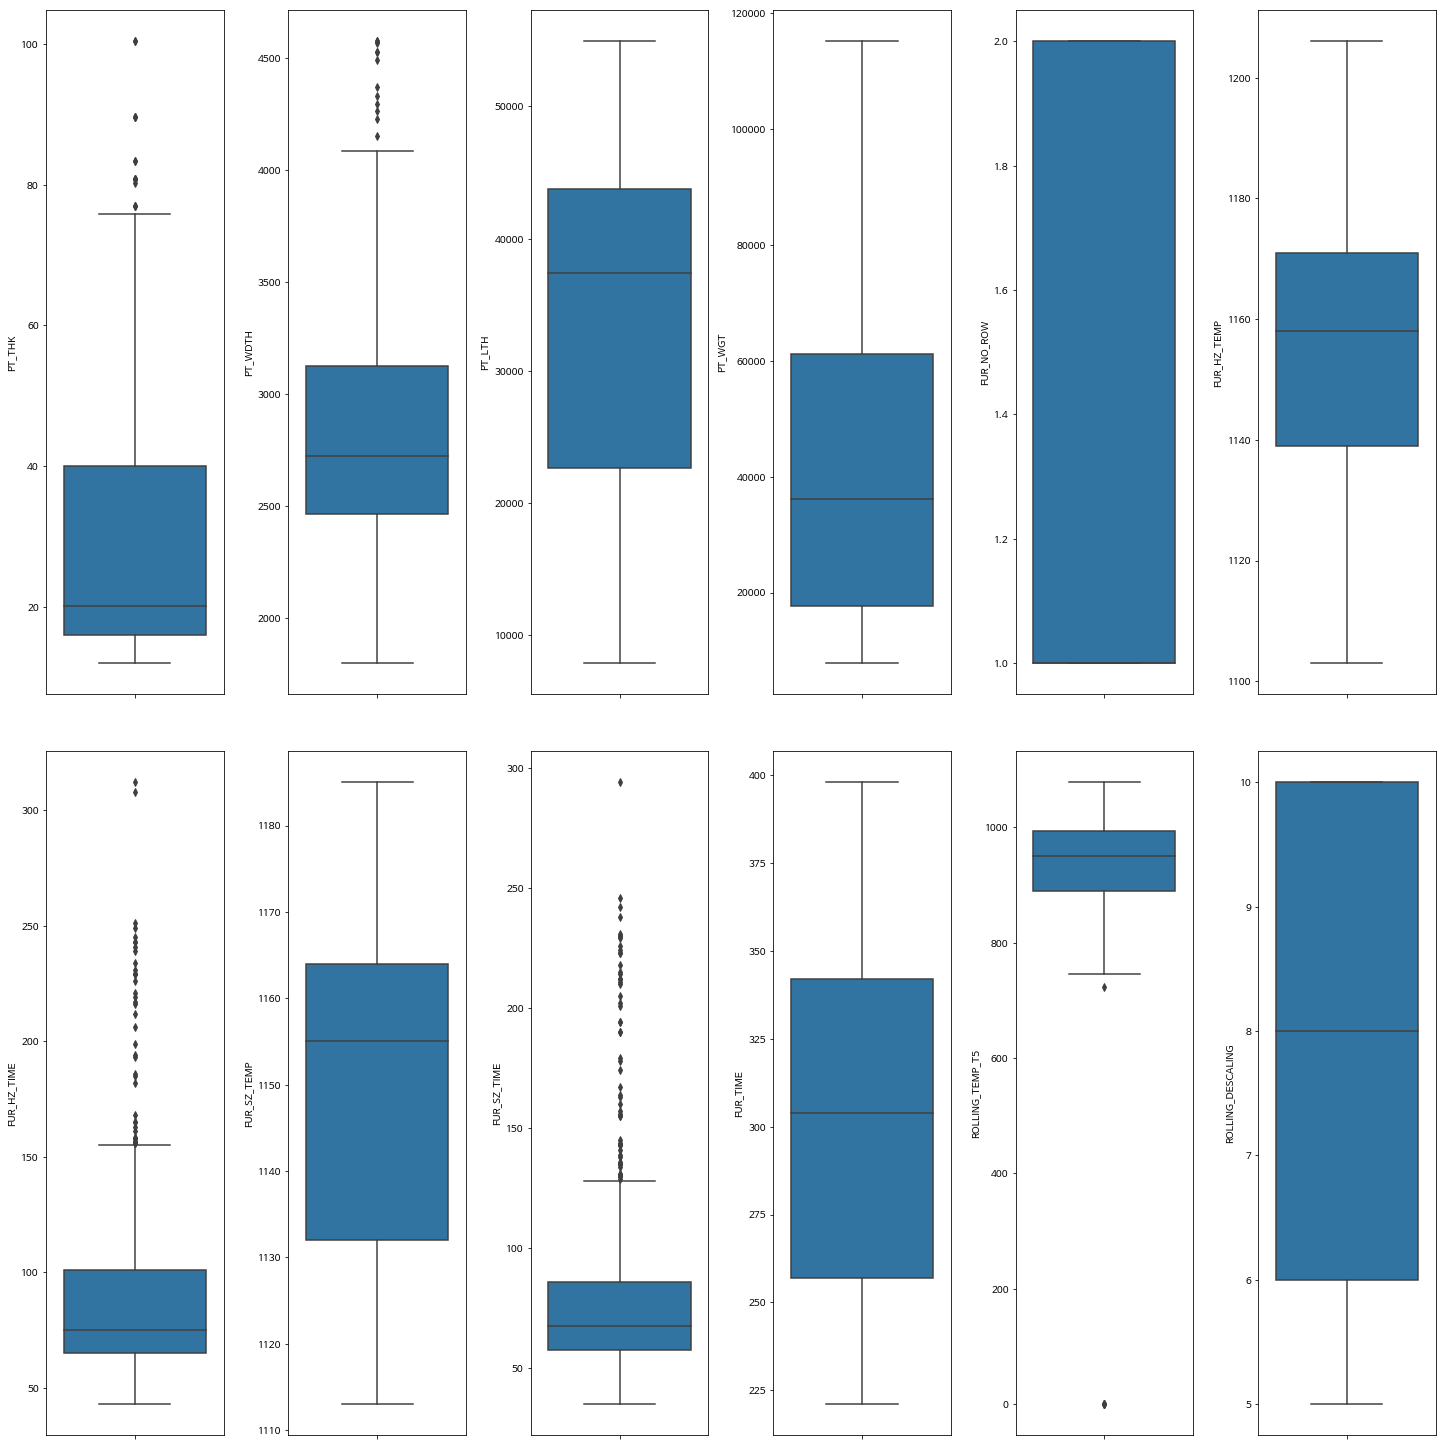

In [51]:
# 이상치 확인
fig, axs = plt.subplots(ncols=6, nrows=2, figsize=(20,20))
index = 0
axs = axs.flatten()
for k,v in ds_scale_select.items():
    sns.boxplot(y=k, data=ds_scale_select, ax=axs[index])
    index+=1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)